# Data import

In [ ]:
import pandas as pd
import os

DATA_FOLDER = './data_v2'
DATA_FILES = [os.path.join(DATA_FOLDER, file) for file in  os.listdir(DATA_FOLDER)]

datasets = {data: pd.read_json(data, lines=True) for data in DATA_FILES}

# Dataset analysys

## Null values

In [ ]:
for dataset_name, dataset in datasets.items():
  null_dict = dataset.isnull().sum()
  print(f"DATASET {dataset_name}: ")
  print('---------------------------')
  for key, val in null_dict.items():
    print(f"{key:<15}: {val:<10}")
  print('===========================')
    

## IDS = -1

In [ ]:
for dataset_name, dataset in datasets.items():
  id_candidates = [key for key in dataset.keys() if 'id' in key]
  negative_ids = 0
  for id_candidate in id_candidates:
    negative_ids += len(dataset[dataset[id_candidate] == -1])
  print(f"DATASET {dataset_name}: ")
  print('---------------------------')
  print(f"Negative id\'s: {negative_ids:<10}")
  print('===========================')

## Wnioski

Wyraźnie widać, że wcześniejsze problemy z danymi już nie występują. Możemy zatem przejść do faktycznej analizy danych pod względem biznesowym

# Analiza danych

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
artists = pd.read_json("data_v2/artists.jsonl", lines=True)
sessions = pd.read_json("data_v2/sessions.jsonl", lines=True)
track_storage = pd.read_json("data_v2/track_storage.jsonl", lines=True)
tracks = pd.read_json("data_v2/tracks.jsonl", lines=True)
users = pd.read_json("data_v2/users.jsonl", lines=True)

pd.set_option('mode.chained_assignment', None)

### Session event types

In [ ]:
sessions['event_type'].unique()

Interesujące dla nas mogą być zdarzenia: 'PLAYED', 'LIKE' i 'SKIP'

In [ ]:
sessions_play = sessions[sessions['event_type'] == 'PLAY']
sessions_like = sessions[sessions['event_type'] == 'LIKE']
sessions_skip = sessions[sessions['event_type'] == 'SKIP']

sessions_sorted_dict = {'play': sessions_play, 'like':sessions_like, 'skip': sessions_skip}

Timestamps

In [ ]:
for event, session_data in sessions_sorted_dict.items():
  print(f"{event}: {session_data['timestamp'].min()} - {session_data['timestamp'].max()}")

Mamy do czynienia z danymi z przedziału 4 miesięcy - od 9.01 do 10.04

Połączenie danych z utworami i artystami + segregacja po miesiącu wydarzenia

In [ ]:
def get_week(date):
  return date.week


for key, session_data in sessions_sorted_dict.items():
  merged = session_data.merge(tracks[['id', 'id_artist']], left_on='track_id', right_on='id', how='left')
  merged = merged.merge(artists[['id', 'name']], left_on='id_artist', right_on='id', how='left')

  # This will be removed in actual analysis
  merged = merged[merged['timestamp'] < '2023-04-10']

  merged['weeks_ordered'] = merged['timestamp'].apply(get_week)
  sessions_sorted_dict[key] = merged


In [ ]:
max_week = sessions_sorted_dict['play']['weeks_ordered'].max()
min_week = sessions_sorted_dict['play']['weeks_ordered'].min()


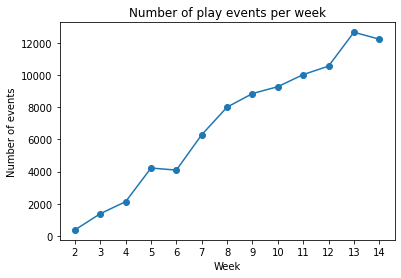

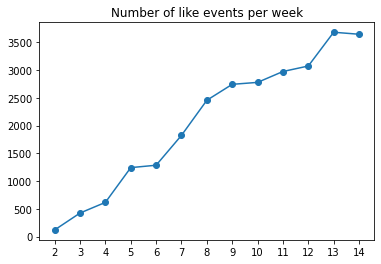

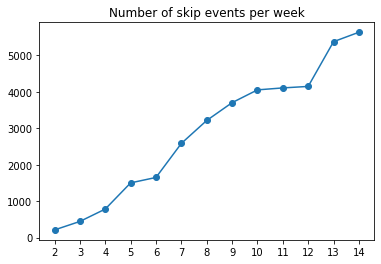

In [15]:
plt.xlabel("Week")
plt.ylabel("Number of events")
for key, session_data in sessions_sorted_dict.items():
    plt.title(f"Number of {key} events per week")
    plt.plot(session_data.groupby('weeks_ordered').size(), label=key, marker='o')
    plt.xticks(range(min_week, max_week + 1, 1))
    plt.show()


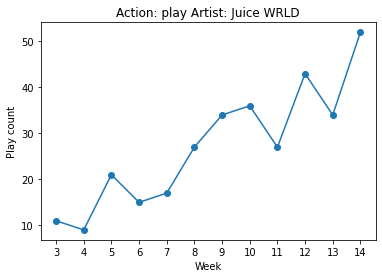

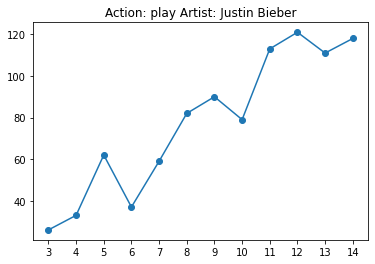

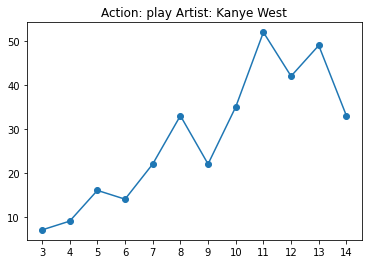

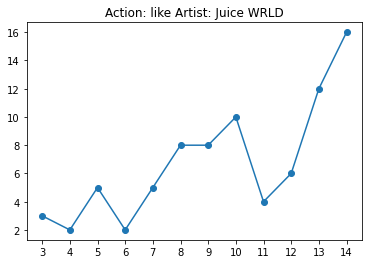

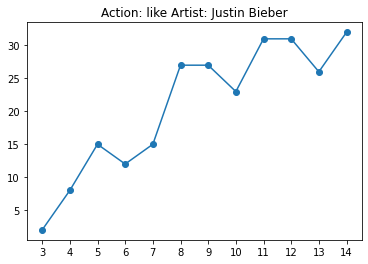

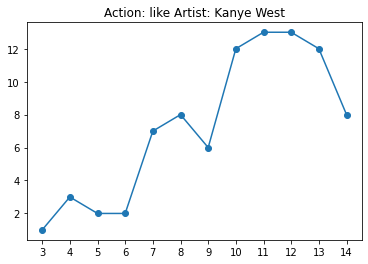

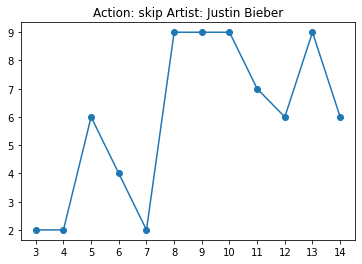

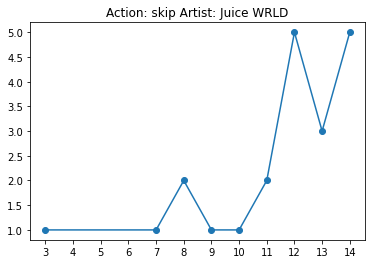

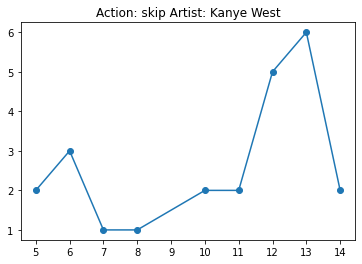

In [14]:
NUMBER_OF_ARTISTS_TO_PLOT = 10
ARTISTS_POPULAR = ["Kanye West", "Justin Bieber", "Juice WRLD"]
ARTISTS_LESS_POPULAR = ["Amorphis", "Angra", "Biffy Clyro"]
fully_plotted_artists = []
plt.xlabel("Week")
plt.ylabel("Play count")

for action in sessions_sorted_dict.keys():
    for artist in sessions_sorted_dict[action]['name'].unique():
        if artist in ARTISTS_POPULAR:
            plt.title(f"Action: {action} Artist: {artist}")
            plt.xticks(range(min_week, max_week + 1, 1))
            plt.plot(sessions_sorted_dict[action][sessions_sorted_dict[action]['name'] == artist].groupby('weeks_ordered').size(), label=artist, marker='o')
            plt.show()

### Inne przydatne kolumny

Warto wziąć pod uwagę niektóre z cech utorów takie jak długość utworu, jego popularność i explicit kontent, które mogą dodatkowo wpływać na ilość odtworzeń / ostateczne wynagrodzenie artysty.

### Popularity

In [23]:
print("Most popular:")
print(tracks.sort_values(by='popularity', ascending=False)[['name', 'popularity']].head(10))
print("=============================================")
print("Least popular:")
print(tracks.sort_values(by='popularity', ascending=True)[['name', 'popularity']].head(10))
print("=============================================")

Most popular:
                     name  popularity
58504     drivers license          99
124052          telepatía          97
23282           positions          92
8378                  911          91
128281  Someone You Loved          90
65890              Anyone          90
98264      Therefore I Am          90
15077             Whoopty          89
9467               Arcade          89
32754            Believer          88
Least popular:
                                            name  popularity
40921                            Rondine Al Nido           0
42636                                   Agg Lagi           0
62933                A Lo Gaucho - Remasterizado           0
42646                                 Mr. Dollar           0
42654                       Weeping Willow Blues           0
126875  Work My Beats 2010 - Original 2010 Remix           0
12220                     Kahe Ko Mohe Chhede Re           0
42656             Insomnia - Live in Krakow 2009           0
1156

### Duration

In [25]:
print("The longest:")
print(tracks.sort_values(by='duration_ms', ascending=False)[['name', 'duration_ms']].head(10))
print("=============================================")
print("The shortest:")
print(tracks.sort_values(by='duration_ms', ascending=True)[['name', 'duration_ms']].head(10))
print("=============================================")

The longest:
                                                     name  duration_ms
35032                                       Surah Al-Araf      4995083
32734                                       Surah An-Nisa      4797258
7039    Monster Tunes Yearmix 2011 - Mixed by Mark Eteson      4792587
2025                                    Surah Aal-E-Imran      4725264
37113                                          L'Etranger      4585640
107447      Nightbreed 2017 Yearmix - Full Continuous Mix      4548907
40762                  Moppen Aan Den Toog, Deel 1 - Live      4142067
103165                              Ocean Waves for Sleep      4120258
126200   Monster Tunes Yearmix 2013 - Contiunous DJ Mix 1      3822752
40764   Sampooran Sundar Kand (Shri Ram Charit Manas - 1)      3682254
The shortest:
                                 name  duration_ms
40516                     Pause Track         3344
109903                    Pause Track         4000
116160                    Pause Track  

# Wnioski końcowe

### Dane wejściowe i wyjściowe modelu

Na powyższych wykresach widać tendencje wzrostową / spadkową dla interakcji użytkowników z utowrami muzycznymi danych artystów. Po obrobieniu danych nasz model będzie przyjmować na wejście słownik, z którego kluczem będzie nazwa zespołu a wartością kolejno słowniki odpowiadające parom tydzień - ilośc akcji (kolejno SKIP, PLAY i LIKE). Dodatkowo na tej podstawie wyliczany będzie średni czas słuchania artysty. Na tej podstawie model będzie kategoryzować artystów na tych stabilnych, dobrze i słabo prosperujących.